# Classification trials

In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as mr
from azure.storage.blob import BlobServiceClient
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

In [200]:
%aimport src.altair_helpers
from src.altair_helpers import (
    plot_altair_grid,
    alt_plot_metric_based_threshold_tuning_plots,
)

%aimport src.business_helpers
from src.business_helpers import int_income_calculator

%aimport src.custom_learning_curve_helpers
from src.custom_learning_curve_helpers import learning_curve, manual_learning_curve

%aimport src.custom_permutation_importance_helpers
from src.custom_permutation_importance_helpers import manual_plot_permutation_importance

%aimport src.custom_threshold_tuning_plotting_helpers
from src.custom_threshold_tuning_plotting_helpers import (
    plot_cost_function_based_threshold_tuning_plots,
    plot_metric_based_threshold_tuning_plots,
)

%aimport src.custom_transformers
import src.custom_transformers as ct

%aimport src.custom_returns_plotter
from src.custom_returns_plotter import plot_returns

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import get_best_pipes, gridsearch

%aimport src.ml_metrics_v2
from src.ml_metrics_v2 import (
    threshold_roc_auc_score,
    threshold_fpr_score,
    threshold_recall_score,
    pr_auc_score,
    get_scores,
    get_eval_metrics,
)

%aimport src.threshold_tuning_helpers
from src.threshold_tuning_helpers import (
    get_components_of_returns,
    threshold_tuning_reshaping,
)

%aimport src.visualization_helpers
from src.visualization_helpers import (
    plot_learning_curve,
    plot_permutation_importances,
    plot_grouped_bar_chart,
    plot_grouped_histogram,
    plot_pr_roc_curves,
)

In [4]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.width", 1000)

## About

This notebook will walk through machine learning classification experiments on the raw [Lending Club loans data](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F). A best-performing model will then be determined and assessed in the context of the business use case for this project.i.e. an conservative investor wanting to use the model developed here to predict which loan applications on the [Lending Club platform](https://www.lendingclub.com/), will not [default](https://en.wikipedia.org/wiki/Default_(finance)), and therefore should be funded by them.

## User Inputs

User inputs and helper functions, to be used later, are defined below

In [5]:
raw_data_file_path = "data/raw/lending_club_loans.csv"
cloud_storage = "no"

# From Feature Reduction
nan_threshold = 0.5
non_useful_cols = ["url", "desc"]
datetime_cols = ["issue_d", "last_pymnt_d"]
cols_one_eighteen = [
    "id",
    "member_id",
    "funded_amnt",
    "funded_amnt_inv",
    "grade",
    "sub_grade",
    "emp_title",
]
cols_eighteen_thirtysix = [
    "zip_code",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
]
cols_thirtyseven_end = [
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
]
loan_status = ["Fully Paid", "Charged Off"]
mapping_dictionary_labels = {"loan_status": {"Fully Paid": 1, "Charged Off": 0}}
four_or_less_value_columns = ["pymnt_plan"]

# From Feature Processing
more_than_one_pct_missing_columns = ["pub_rec_bankruptcies"]
datetime_cols_v2 = ["last_credit_pull_d", "earliest_cr_line"]
high_cardinality_cols = ["addr_state"]
mapping_dict_emp_length = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0,
    }
}
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
repeated_data_cols = ["title"]
pct_to_numeric_cols = ["int_rate", "revol_util"]

# From Exploratory Data Analysis 1/2
correlated_features = [
    # "total_acc",
    "installment",
    "fico_range_low",
    "fico_range_high",
]
look_ahead_features = ["last_fico_range_low", "last_fico_range_high"]
raw_labels = ["loan_status"]
new_labels = ["is_default"]

cols_to_show = [
    "preprocessor_type",
    "resamplers",
    "threshold",
    "params",
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "mean_score_time",
    "clf_params",
]

thresholds_list = np.arange(0.01, 1, 0.01)

In [6]:
nan_threshold = float(nan_threshold)
for k in ["Fully Paid", "Charged Off"]:
    mapping_dictionary_labels["loan_status"][k] = int(
        mapping_dictionary_labels["loan_status"][k]
    )
for k in [
    "10+ years",
    "9 years",
    "8 years",
    "7 years",
    "6 years",
    "5 years",
    "4 years",
    "3 years",
    "2 years",
    "1 year",
    "< 1 year",
    "n/a",
]:
    mapping_dict_emp_length["emp_length"][k] = int(
        mapping_dict_emp_length["emp_length"][k]
    )

# From Exploratory Data Analysis 2/2
mapping_dict_new_labels = {"is_default": {0: 1, 1: 0}}

In [7]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "fpr": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=0.5,
    ),
    "roc_auc_binary": mr.make_scorer(
        threshold_roc_auc_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "pr_auc": mr.make_scorer(
        pr_auc_score,
        greater_is_better=True,
        needs_proba=True,
    ),
}
cols_to_show = [
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_roc_auc_binary",
    "mean_test_pr_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_roc_auc_binary",
    "mean_train_pr_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "std_train_roc_auc_binary",
    "std_test_roc_auc_binary",
    "std_train_pr_auc",
    "std_test_pr_auc",
    "mean_score_time",
]

## Load data

Raw data from Lending Club is loaded into memory

In [8]:
if cloud_storage == "yes":
    az_storage_container_name = "myconedesx7"
    conn_str = (
        "DefaultEndpointsProtocol=https;"
        f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT')};"
        f"AccountKey={os.getenv('AZURE_STORAGE_KEY')};"
        f"EndpointSuffix={os.getenv('ENDPOINT_SUFFIX')}"
    )
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)

    blobstrings = {}
    for blob_name in ["blobedesz38"]:
        blob_client = blob_service_client.get_blob_client(
            container=az_storage_container_name, blob=blob_name
        )
        blobstring = blob_client.download_blob().content_as_text()
    df = pd.read_csv(StringIO(blobstring), skiprows=1, low_memory=False)
else:
    df = pd.read_csv(raw_data_file_path, skiprows=0, low_memory=False)

## Train-Test split

A hold-out set of the raw data will be set aside for model assessment

In [9]:
df_train_val, df_test = train_test_split(df, test_size=0.33, random_state=4321)
df_train, df_val = train_test_split(df_train_val, test_size=0.33, random_state=4321)

## Data processing

The raw data is cleaned, filtered and features are extracted/selected from this processed data in order to run experiments in classification

In [10]:
pipe_1_2_3 = Pipeline(
    [
        # nan_threshold=0.5, is a float in [0, 1.0] - CAN CHANGE OR KEEP UNCHANGED
        ("nanthresh", ct.DFNanThresholdColumnDropper(0.5)),
        ("nouse", ct.DFColumnDropper(non_useful_cols)),
        ("dtime", ct.DFColumnDropper(datetime_cols)),
        ("c1", ct.DFColumnDropper(cols_one_eighteen)),
        ("c2", ct.DFColumnDropper(cols_eighteen_thirtysix)),
        ("c3", ct.DFColumnDropper(cols_thirtyseven_end)),
        (
            "mapstatus",
            ct.DFColumnFilterList("loan_status", loan_status),
        ),
        ("colmap", ct.DFColumnMapper(mapping_dictionary_labels)),
        ("onevals", ct.DFNonUniqueValColDropper(num_non_unique_vals=1)),
        # four_or_less_value_columns=['pymnt_plan'] - 'pymnt_plan' is MOSTLY 'n', EXCLUDE
        ("fourvals", ct.DFColumnDropper(four_or_less_value_columns)),
        # more_than_one_pct_missing_columns = ['pub_rec_bankruptcies']
        ("morethan1pctnan", ct.DFColumnDropper(more_than_one_pct_missing_columns)),
        ("nan", ct.DFDropNaN()),
        # high_cardinality_cols=['addr_state'] - CAN INCLUDE OR EXCLUDE
        ("hcardcols", ct.DFColumnDropper(high_cardinality_cols)),
        ("dtimev2", ct.DFColumnDropper(datetime_cols_v2)),
        ("texttonum", ct.DFColumnMapper(mapping_dict_emp_length)),
        ("repeats", ct.DFColumnDropper(repeated_data_cols)),
        ("pctcols", ct.DFPctNumeric(pct_to_numeric_cols, "%")),
        (
            "singlecolmap",
            ct.DFSingleColumnMapper("loan_status", mapping_dict_new_labels),
        ),
        ("dtype", ct.DFSimpleDtypeChanger(new_labels, "int")),
        # n_std is an integer - CAN CHANGE OR KEEP UNCHANGED
        ("stdfilter", ct.DFColumnStdFilter("annual_inc", 3)),
        # correlated_features=['total_acc','installment','fico_range_low','fico_range_high'] EXCLUDE
        ("corr", ct.DFColumnDropper(correlated_features)),
        ("lookahead", ct.DFColumnDropper(look_ahead_features)),
        ("label", ct.DFColumnDropper(raw_labels)),
        # requires ("corr", ...) to be removed; threshold=1, ideally chosen from dendogram
        # ("clusterselect", ct.DFHierarchicalClusterSpearmanRank(threshold=1)),
    ]
)
df_pipe_transformed_train = pipe_1_2_3.fit_transform(df_train)
df_pipe_transformed_val = pipe_1_2_3.transform(df_val)
df_pipe_transformed_train_val = pipe_1_2_3.transform(df_train_val)
df_pipe_transformed_test = pipe_1_2_3.transform(df_test)
print(df_pipe_transformed_train.shape)
print(df_pipe_transformed_val.shape)
print(df_pipe_transformed_train_val.shape)
print(df_pipe_transformed_test.shape)
display(df_pipe_transformed_train.head(2))
display(df_pipe_transformed_val.head(2))
display(df_pipe_transformed_train_val.head(2))
display(df_pipe_transformed_test.head(2))
display(df_pipe_transformed_train["is_default"].squeeze().value_counts(dropna=False))

(16998, 17)
(8347, 17)
(25361, 17)
(12469, 17)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,22.0,0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,17.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,20.0,0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,13.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
39296,15250.0,36 months,11.34,10,MORTGAGE,75000.0,Not Verified,debt_consolidation,15.14,0.0,0.0,11.0,0.0,39702.0,84.5,18.0,0
2652,6000.0,36 months,15.96,4,RENT,72000.0,Not Verified,credit_card,4.15,0.0,2.0,7.0,0.0,7600.0,82.6,11.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0,1
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0,1


0    14547
1     2451
Name: is_default, dtype: int64

## Get features and class labels from processed data

The features and labels are now extracted from the processed training and testing splits

In [11]:
X_train = df_pipe_transformed_train.drop(labels=new_labels, axis=1)
y_train = df_pipe_transformed_train[new_labels].astype(int).squeeze()
X_val = df_pipe_transformed_val.drop(labels=new_labels, axis=1)
y_val = df_pipe_transformed_val[new_labels].astype(int).squeeze()
X_train_val = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_train_val = df_pipe_transformed_test[new_labels].astype(int).squeeze()
X_test = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_test = df_pipe_transformed_test[new_labels].astype(int).squeeze()
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))
display(X_train_val.head(2))
display(y_train.to_frame().head(2))
display(y_val.to_frame().head(2))
display(y_test.to_frame().head(2))
display(y_train_val.to_frame().head(2))

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,22.0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,17.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,20.0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,13.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0


,is_default
36400,0
20156,0


,is_default
22692,0
13071,0


,is_default
9990,1
27119,1


,is_default
9990,1
27119,1


## Assemble components for `GridSearchCV`

The pipeline inputs and other components required for hyperparameter optimization using `GridSearchCV` are extracted here

### Lists of features by type

A list of numerical and categorical features is extracted from the processed data
- numerical features are those with a datatype of `float`
- categorical features are those that do not have a datatype of `float`

In [12]:
numerical_columns = [
    c
    for c in list(X_train.select_dtypes(exclude="object"))
    if c not in new_labels + ["emp_length"]
]
nominal_columns = list(X_train.select_dtypes(include="object")) + ["emp_length"]
try:
    assert set(numerical_columns + nominal_columns) == set(list(X_train)) - set(
        new_labels
    )
    print("Columns from training data match feature lists")
except AssertionError as e:
    print("Some columns from training data are missing from feature lists")
print("Categoricals:\n-" + "\n-".join(nominal_columns))
print("Numericals:\n-" + "\n-".join(numerical_columns))

Columns from training data match feature lists
Categoricals:
-term
-home_ownership
-verification_status
-purpose
-emp_length
Numericals:
-loan_amnt
-int_rate
-annual_inc
-dti
-delinq_2yrs
-inq_last_6mths
-open_acc
-pub_rec
-revol_bal
-revol_util
-total_acc


### Feature transformations

Below, feature transformations to be applied to all numerical columns are defined. With or without transformations, all numerical features will be normalized. All categorical features will be one-hot encoded.

In [13]:
col_transformers = {
    c: Pipeline(
        steps=[
            ("trans", ct.DFPowerTransformer("yeo-johnson")),
            ("ss", ct.DFStandardScaler()),
        ]
    )
    for c in numerical_columns
}
preprocessors = {
    "no_trans": ColumnTransformer(
        transformers=[
            (
                "nums",
                Pipeline(steps=[("trans", StandardScaler())]),
                numerical_columns,
            )
        ]
        + [("onehot", OneHotEncoder(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
    "trans": ColumnTransformer(
        transformers=[(k, v, [k]) for k, v in col_transformers.items()]
        + [("onehot", OneHotEncoder(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
}

### Classifiers and hyper-parameters for optimization

The models to be compared, discrimination threshold(s) (to be applied to all listed models), and dictionaries of model hyper-parameters for tuning, are defined below
- for hyper-parameter dictionaries containing cost-function weights, for manual specification of the penalties used in the algorithm's cost function, the larger penalty should be assigned to the minority class (see [**Lesson 07. Cost-Sensitive Algorithms**](https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/))
  - here, this is for the positive class where `is_default`==1, and is explicitly shown below through the class-balance of the labels from the training data

In [14]:
y_train.value_counts().to_frame()

,is_default
0,14547
1,2451


In [15]:
vc = np.unique(y_train, return_counts=True)[1]
minority_weight = vc[0] / vc[1]
parameters = {
    "LogisticRegression": {
        "C": [1.0],
        "class_weight": [
            "balanced",
            None,
            {0: 1, 1: 1},
            {0: 1, 1: 5},
            {0: 1, 1: 5.5},
            {0: 1, 1: minority_weight},
            {0: 1, 1: 6},
            {0: 1, 1: 8},
        ],
    },
    "DummyClassifier": {"strategy": ["stratified"]},
}

In [16]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=False)
df_gs = gridsearch(
    X_train,
    y_train,
    parameters,
    preprocessors["no_trans"],
    cv,
    multi_scorers,
    threshold=0.5,
)
param_cols = df_gs.columns[
    df_gs.columns.to_series().str.contains("param_")
].tolist()
display(df_gs[["clf"]+param_cols+cols_to_show])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    3.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


,clf,param_clf__C,param_clf__class_weight,param_clf__strategy,mean_test_recall_binary,mean_test_fpr,mean_test_roc_auc_binary,mean_test_pr_auc,mean_train_recall_binary,mean_train_fpr,mean_train_roc_auc_binary,mean_train_pr_auc,mean_fit_time,std_train_recall_binary,std_test_recall_binary,std_train_fpr,std_test_fpr,std_train_roc_auc_binary,std_test_roc_auc_binary,std_train_pr_auc,std_test_pr_auc,mean_score_time
0,LogisticRegression,1,balanced,NaN,0.629537,0.343577,0.642980,0.286464,0.643717,0.340465,0.651626,0.293861,0.588577,0.005650,0.017472,0.002314,0.010124,0.003529,0.008925,0.002647,0.010325,0.125814
1,LogisticRegression,1,None,NaN,0.022851,0.003849,0.509501,0.286977,0.024072,0.003523,0.510274,0.295986,0.834287,0.001268,0.005075,0.000435,0.001218,0.000695,0.002055,0.002718,0.009664,0.095464
2,LogisticRegression,1,"{0: 1, 1: 1}",NaN,0.022851,0.003849,0.509501,0.286977,0.024072,0.003523,0.510274,0.295986,0.825216,0.001268,0.005075,0.000435,0.001218,0.000695,0.002055,0.002718,0.009664,0.051822
3,LogisticRegression,1,"{0: 1, 1: 5}",NaN,0.533663,0.267892,0.632886,0.286365,0.547735,0.266876,0.640429,0.294081,0.604684,0.005665,0.009538,0.002017,0.010138,0.003780,0.005565,0.002634,0.010221,0.023142
4,LogisticRegression,1,"{0: 1, 1: 5.5}",NaN,0.590780,0.307900,0.641440,0.286386,0.605365,0.307039,0.649163,0.293962,0.552780,0.004671,0.010883,0.002388,0.009242,0.002893,0.007408,0.002661,0.010283,0.024467
5,LogisticRegression,1,"{0: 1, 1: 5.935128518971848}",NaN,0.630354,0.343439,0.643457,0.286418,0.643615,0.340414,0.651600,0.293860,0.588375,0.005460,0.017833,0.002275,0.010071,0.003478,0.009218,0.002648,0.010275,0.030386
6,LogisticRegression,1,"{0: 1, 1: 6}",NaN,0.636065,0.348045,0.644010,0.286397,0.650143,0.345673,0.652235,0.293843,0.630847,0.005297,0.020712,0.001696,0.009682,0.003242,0.010992,0.002654,0.010319,0.023752
7,LogisticRegression,1,"{0: 1, 1: 8}",NaN,0.767438,0.485462,0.640988,0.286240,0.776928,0.483794,0.646567,0.293485,0.346988,0.002226,0.022427,0.005247,0.005766,0.003128,0.011478,0.002673,0.010304,0.012179
8,DummyClassifier,NaN,NaN,stratified,0.152179,0.142435,0.504872,0.213493,0.154019,0.141180,0.506419,0.215637,0.054413,0.003669,0.011319,0.000614,0.001917,0.002142,0.006618,0.003403,0.010556,0.018033


CPU times: user 1.26 s, sys: 2.9 s, total: 4.16 s
Wall time: 4.4 s


In [17]:
best_cfg_idx = 0
best_dummy_cfg_idx = 8
best_pipe, best_dummy_pipe = get_best_pipes(
    best_cfg_idx, best_dummy_cfg_idx, df_gs, preprocessors["no_trans"], param_cols
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('trans',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'revol_util', 'total_acc']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['term', 'home_ownership',
        

In [18]:
_, confs = get_components_of_returns(X_val)
confs

[{'r': 10.71, 'n': ' 36 months', 'p': 500.0, 'ret': 86.82798290297922},
 {'r': 7.9, 'n': ' 36 months', 'p': 35000.0, 'ret': 4425.720020766101},
 {'r': 23.59, 'n': ' 60 months', 'p': 35000.0, 'ret': 24914.007363151228},
 {'r': 14.91, 'n': ' 60 months', 'p': 9900.0, 'ret': 4203.172176331318}]

In [19]:
%%time
best_pipe.fit(X_train, y_train)
best_dummy_pipe.fit(X_train, y_train)
y_probs_val = best_pipe.predict_proba(X_val)[:, 1]

CPU times: user 665 ms, sys: 1.03 s, total: 1.69 s
Wall time: 187 ms


In [181]:
%%time
df_threshold_tuning_scores, df_all_threshold_tuning_scores = plot_metric_based_threshold_tuning_plots(
    y_val, y_probs_val, thresholds_list, legend_position=(1.01, 1), show_best_t_by_f1=False, show_plot=False, fig_size=(8, 4)
)
display(df_threshold_tuning_scores)

,best_threshold,score
ROC-AUC,0.49,0.639368
Precision,0.90,0.949285
Recall,0.01,1.000000
F1,0.32,0.693046
FPR,0.01,1.000000


CPU times: user 172 ms, sys: 53.5 ms, total: 226 ms
Wall time: 436 ms


In [182]:
alt_plot_metric_based_threshold_tuning_plots(
    df_all_threshold_tuning_scores,
    ptitle_offset=-5,
    legend_offset=5,
    figsize=(450, 300),
)

alt.LayerChart(...)

1. Why divide by `len(y_test)`?
   - If every loan had these r,n,p, anbd other factos were consisnt, and taking the model's predictive power into account, then the average return would be given by `ds /= len(y_test)`

,r,n,p,config,best_t,return_at_best_t,theoretical,clf
0,10.71,36,500.0,0,0.01,-6.374047,86.827983,DummyClassifier
1,7.90,36,35000.0,1,0.01,-1463.615562,4425.720021,DummyClassifier
2,23.59,60,35000.0,2,0.01,11152.869036,24914.007363,DummyClassifier
3,14.91,60,9900.0,3,0.01,1403.403017,4203.172176,DummyClassifier
4,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
5,7.90,36,35000.0,1,0.61,-371.397904,4425.720021,LogisticRegression
6,23.59,60,35000.0,2,0.90,16657.707551,24914.007363,LogisticRegression
7,14.91,60,9900.0,3,0.83,2265.027300,4203.172176,LogisticRegression


config,threshold,0,1,2,3,r,n,p,config,best_t,return_at_best_t,theoretical,clf
0,0.01,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
1,0.02,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
2,0.03,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
3,0.04,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
4,0.05,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression


CPU times: user 934 ms, sys: 1.51 s, total: 2.45 s
Wall time: 1.19 s


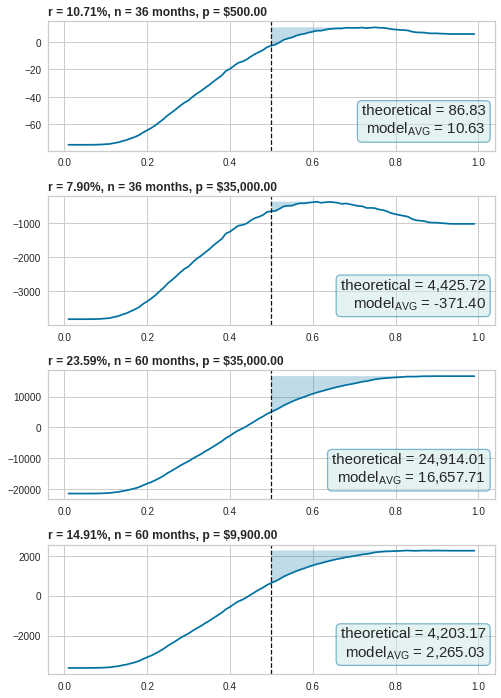

In [21]:
%%time
df_returns_t_tuned, df_returns_t_tuning_full = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, thresholds_list)
display(df_returns_t_tuned)
display(df_returns_t_tuning_full.head())

In [22]:
%%time
best_t = 0.75
df_returns_best_t, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, [best_t])
df_returns_best_t = threshold_tuning_reshaping(df_returns_best_t)
display(df_returns_best_t)

,cfg,clf,return
0,"(10.71%, 36 mo., $500)",DummyClassifier,-6.374047
1,"(7.90%, 36 mo., $35,000)",DummyClassifier,-1463.615562
2,"(23.59%, 60 mo., $35,000)",DummyClassifier,11152.869036
3,"(14.91%, 60 mo., $9,900)",DummyClassifier,1403.403017
4,"(10.71%, 36 mo., $500)",LogisticRegression,10.626142
5,"(7.90%, 36 mo., $35,000)",LogisticRegression,-560.621189
6,"(23.59%, 60 mo., $35,000)",LogisticRegression,15614.988442
7,"(14.91%, 60 mo., $9,900)",LogisticRegression,2171.511279
8,"(10.71%, 36 mo., $500)",Theoretical,86.827983
9,"(7.90%, 36 mo., $35,000)",Theoretical,4425.720021


CPU times: user 322 ms, sys: 582 ms, total: 904 ms
Wall time: 358 ms


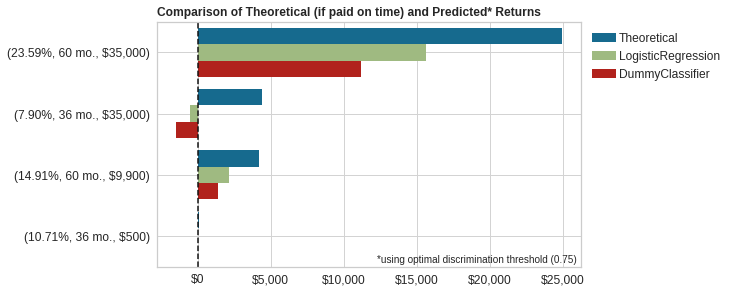

In [52]:
plot_returns(
    df_returns_best_t.sort_values(by=["clf", "return"], ascending=[False, False]),
    ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
    annotation_text=f"*using optimal discrimination threshold ({best_t})",
    axis_tick_fontsize=12,
    annotation_text_fontsize=10,
    annotation_loc=(0.99, 0.01),
    fig_size=(8, 4),
)

1. It is average becuase the model will not alwyas predict that you should fund such a loan. There are times when it incorrectly predicts that the loan should not be funded - in such a scenario, prospective return is lost. If you used an independent methd of predicting loans to fund, and the loan was paid off on time, then the return you earn would be the theoretical return from the above graph/table.

In [24]:
%%time
best_pipe.fit(X_train_val, y_train_val)
best_dummy_pipe.fit(X_train_val, y_train_val)
y_probs_test = best_pipe.predict_proba(X_test)[:, 1]

CPU times: user 654 ms, sys: 1.35 s, total: 2.01 s
Wall time: 206 ms


In [25]:
_, confs_test = get_components_of_returns(X_train_val)
confs_test

[{'r': 8.07, 'n': ' 36 months', 'p': 500.0, 'ret': 64.63602189022333},
 {'r': 10.46, 'n': ' 36 months', 'p': 500.0, 'ret': 84.70453976034196},
 {'r': 7.49, 'n': ' 36 months', 'p': 35000.0, 'ret': 4188.048351118239},
 {'r': 23.52, 'n': ' 60 months', 'p': 35000.0, 'ret': 24829.067510758083},
 {'r': 17.27, 'n': ' 36 months', 'p': 10000.0, 'ret': 2883.408919678688}]

In [26]:
%%time
df_returns_best_t_test, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_test, y_test, confs_test, [best_t])
df_returns_best_t_test = threshold_tuning_reshaping(df_returns_best_t_test)
display(df_returns_best_t_test)

,cfg,clf,return
0,"(8.07%, 36 mo., $500)",DummyClassifier,-20.988655
1,"(10.46%, 36 mo., $500)",DummyClassifier,-8.618246
2,"(7.49%, 36 mo., $35,000)",DummyClassifier,-1676.610825
3,"(23.52%, 60 mo., $35,000)",DummyClassifier,11046.692829
4,"(17.27%, 36 mo., $10,000)",DummyClassifier,560.741114
5,"(8.07%, 36 mo., $500)",LogisticRegression,-9.458296
6,"(10.46%, 36 mo., $500)",LogisticRegression,6.131059
7,"(7.49%, 36 mo., $35,000)",LogisticRegression,-923.455263
8,"(23.52%, 60 mo., $35,000)",LogisticRegression,15110.622176
9,"(17.27%, 36 mo., $10,000)",LogisticRegression,1046.491202


CPU times: user 431 ms, sys: 820 ms, total: 1.25 s
Wall time: 360 ms


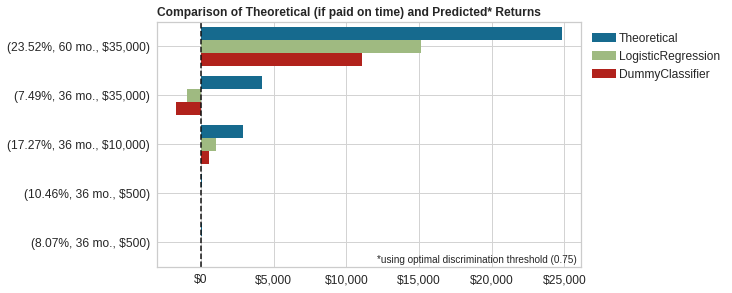

In [53]:
plot_returns(
    df_returns_best_t_test.sort_values(by=["clf", "return"], ascending=[False, False]),
    ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
    annotation_text=f"*using optimal discrimination threshold ({best_t})",
    axis_tick_fontsize=12,
    annotation_text_fontsize=10,
    annotation_loc=(0.99, 0.01),
    fig_size=(8, 4),
)

In [28]:
df_scores, y_pred_test_selected_threshold = get_eval_metrics(
    y_test.to_numpy(), y_probs_test, split="test", threshold=best_t
)
display(df_scores.T)

,0
test_recall_binary,0.159797
test_fpr,0.047299
test_pr_auc,0.276734
test_roc_auc,0.556249


In [70]:
df_cm = (
    pd.DataFrame(
        mr.confusion_matrix(
            y_test,
            y_pred_test_selected_threshold,
            labels=np.sort(np.unique(y_train_val)),
        ),
        index=np.sort(np.unique(y_train_val)),
        columns=np.sort(np.unique(y_train_val)),
    )
    .rename_axis("actual", axis="columns")
    .rename_axis("predicted", axis="rows")
)
df_cr = pd.DataFrame(
    mr.classification_report(
        y_test,
        y_pred_test_selected_threshold,
        target_names=np.sort(np.unique(y_train_val)),
        output_dict=True,
    )
).T
plot_altair_grid(
    df_cm,
    df_cr,
    ptitle_offset=-5,
    cpe_figsize=(150, 300),
    cm_figsize=(150, 300),
    cr_figsize=[(250, 300), (100, 300)],
)

alt.HConcatChart(...)

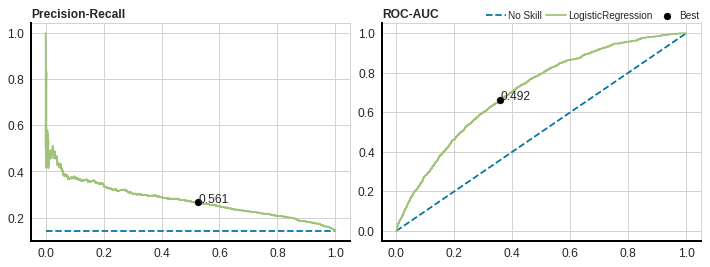

In [50]:
plot_pr_roc_curves(
    y_test,
    y_probs_test,
    type(best_pipe.named_steps["clf"]).__name__,
    axis_tick_label_fontsize=12,
    wspace=0.1,
    legend_position=(0.3, 1.1),
    fig_size=(12, 4),
)

CPU times: user 5.34 s, sys: 1.01 s, total: 6.35 s
Wall time: 34.8 s


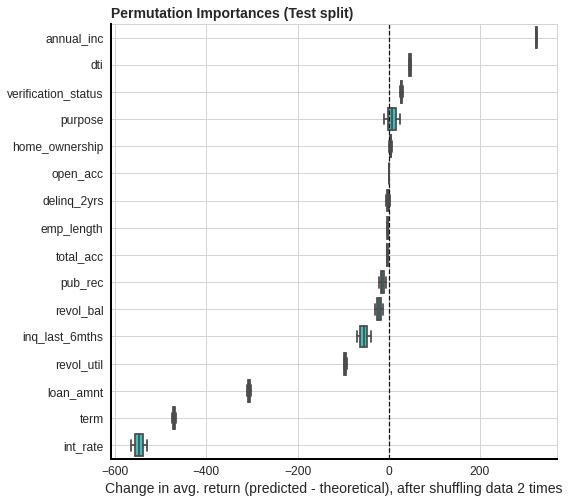

In [236]:
%%time
manual_plot_permutation_importance(
    X_test,
    y_test,
    best_pipe,
    best_t,
    2,
    "test",
    "Permutation Importances",
    14,
    12,
    14,
    "cyan",
    (8,8),
)

1. For a given (`r`, `n`, `P`), calculate
   - average predicted return per loan ( $\overline{A}$ )
     - assumption: every loan in dataset has this (`r`, `n`, `P`)
     - A. calculate overall predicted return using formula for `ds`
       - this takes ML model's predictive power into account
     - B. divide overall predicted return by number of loans
       - this gives the average return predicted by the model, per loan
   - theoretical return (`T`)
     - this is the sum of `n` [monthly returns](https://www.vertex42.com/ExcelArticles/amortization-calculation.html) that a prospective funder of the loan would expect to receive if the loan is paid off on time
   - difference (`D`) between average predicted and theoretical return
     - `D` = $\overline{A}$ - `T`
2. Calculate mean of the differences ( $\overline{D}$ )
3. Shuffle single ML feature and re-calculate mean of differences ( $\overline{D}$ ) from step 2.
4. Calculate difference (`D1`) bewteen mean values found in steps 2. (without shuffling) and 3. (with shuffling)
5. Repeat steps 2. to 4. 10 times
   - in other words, shuffle the same column 10 times and calculate the differences (`D2`, ..., `D10`) between mean values found in steps 2. (without shuffling) and 3. (with shuffling)
6. Plot all the differences `D1`, ..., `D10`
7. The higher the difference the more impactful the ML feature is to the predictive model developed here

In [233]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=best_t,
    ),
    "fpr": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
}

CPU times: user 263 ms, sys: 354 ms, total: 617 ms
Wall time: 1.9 s


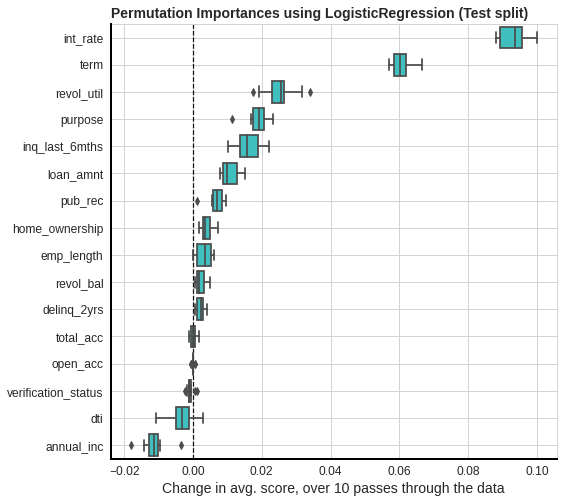

In [234]:
%%time
plot_permutation_importances(
    best_pipe,
    X_test,
    y_test,
    scorer=multi_scorers["recall_binary"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(8, 8),
)

CPU times: user 479 ms, sys: 904 ms, total: 1.38 s
Wall time: 1.03 s


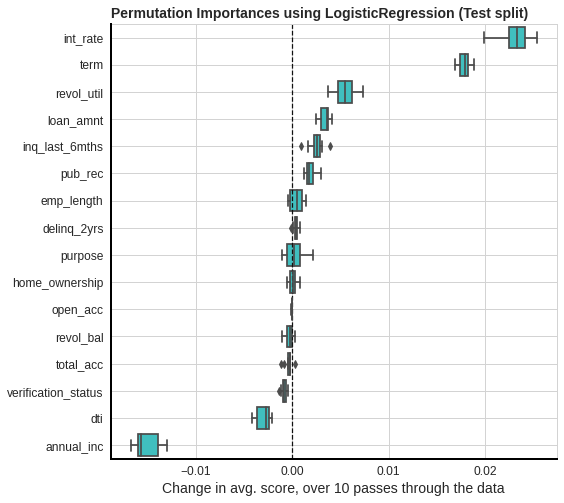

In [235]:
%%time
plot_permutation_importances(
    best_pipe,
    X_test,
    y_test,
    scorer=multi_scorers["fpr"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(8, 8),
)

In [214]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
X_all = pd.concat([X_train_val.iloc[:, :], X_test.iloc[:, :]]).reset_index(drop=True)
y_all = pd.concat([y_train_val[:], y_test[:]]).reset_index(drop=True)

CPU times: user 93.3 ms, sys: 79 µs, total: 93.4 ms
Wall time: 89.7 ms


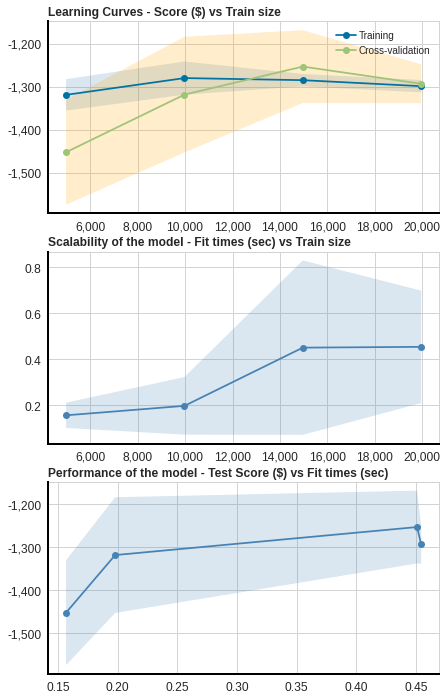

In [230]:
%%time
scores, train_sizes = learning_curve(best_pipe, X_all, y_all, cv, 5, best_t)
scores_grouped = scores.groupby(["train_size"]).agg({"train_err": ["mean", "std"], "test_err": ["mean", "std"], "fit_time": ["mean", "std"], "clf":"first"}).reset_index()
scores_grouped.columns = scores_grouped.columns.map('|'.join)
display(scores_grouped)
manual_learning_curve(
    scores_grouped,
    alpha=0.2,
    hspace=0.2,
    wspace=0.2,
    axis_tick_label_fontsize=12,
    figsize=(7, 12),
)

CPU times: user 245 ms, sys: 15.5 ms, total: 261 ms
Wall time: 1.78 s


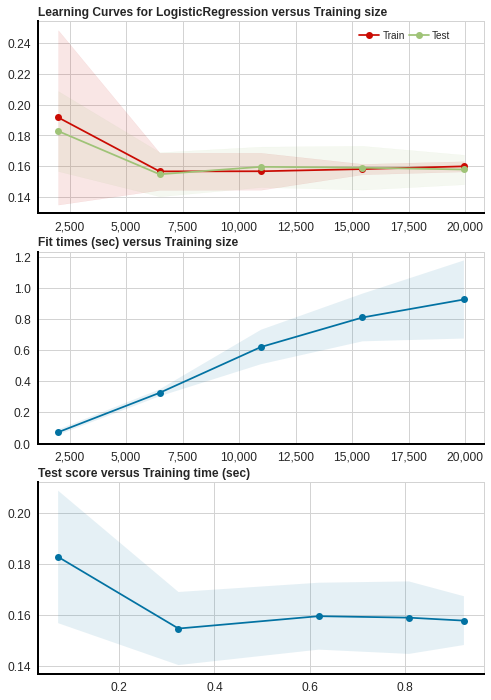

In [231]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["recall_binary"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

CPU times: user 238 ms, sys: 24 ms, total: 262 ms
Wall time: 1.71 s


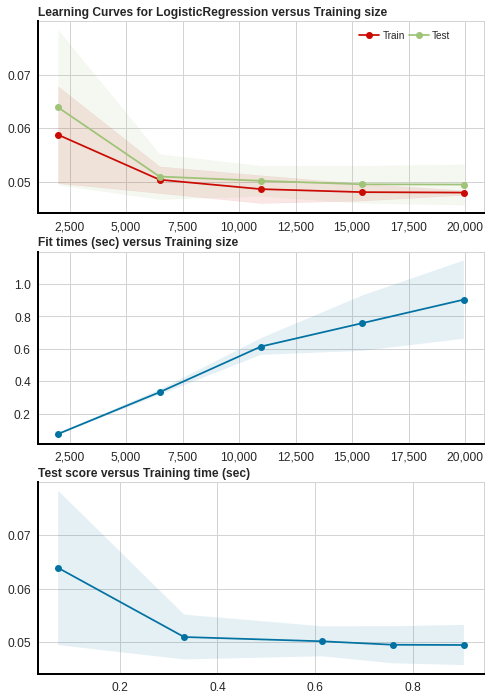

In [232]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["fpr"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

In [41]:
# y_pred_test_selected_threshold_series = pd.Series(
#     y_pred_test_selected_threshold, index=X_test.index, name="pred"
# )
# df_tp = df[["addr_state"]].merge(
#     pd.concat(
#         [
#             X_test[
#                 [
#                     "purpose",
#                     "home_ownership",
#                     "emp_length",
#                     "term",
#                 ]
#                 + numerical_columns
#             ],
#             y_test,
#             y_pred_test_selected_threshold_series,
#         ],
#         axis=1,
#     ),
#     left_index=True,
#     right_index=True,
#     how="inner",
# )

In [42]:
# df_tp["misclassified"] = df_tp["is_default"] != df_tp["pred"]
# display(df_tp)
# display(df_tp.dtypes.to_frame())

In [43]:
# for c in numerical_columns:
#     plot_grouped_histogram(df_tp, c, (0.675, 1.1), 0.5, 0.15, (12, 4))

In [44]:
# for col, wspace, fig_size in zip(
#     ["home_ownership", "purpose", "emp_length", "term", "addr_state"],
#     [0.25, 0.4, 0.1, 0.25, 0.1],
#     [(12, 4), (12, 4), (12, 4), (12, 4), (12, 8)],
# ):
#     plot_grouped_bar_chart(df_tp, col, "misclassified", wspace, fig_size=fig_size)

## Links
1. [Find row closest to a value](https://stackoverflow.com/a/52587453/4057186)